## NLP PIPELINE

**Five Pipeline will be used and the best will be stated based on some appropriate metrics (accuracy and F1 score)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import re
#pip install wordcloud
from wordcloud import WordCloud
import pandas as pd
import spacy
import string
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

In [3]:
#reading in data
df = pd.read_json('CETM47-22_23-AS2-Data.json')
df.head()

,text,date,label,id,label_name
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,4,1170516324419866624,sports_&_gaming
1,I would rather hear Eli Gold announce this Aub...,2019-09-08,4,1170516440690176006,sports_&_gaming
2,"Someone take my phone away, I’m trying to not ...",2019-09-08,4,1170516543387709440,sports_&_gaming
3,"A year ago, Louisville struggled to beat an FC...",2019-09-08,4,1170516620466429953,sports_&_gaming
4,Anyone know why the #Dodgers #Orioles game nex...,2019-09-08,4,1170516711411310592,sports_&_gaming


In [4]:
#shape of the data
df.shape

(6443, 5)

In [5]:
#checking null values
df.isna().sum()

text          0
date          0
label         0
id            0
label_name    0
dtype: int64

In [6]:
#checking the unique label
set(df.label_name) 

{'arts_&_culture',
 'business_&_entrepreneurs',
 'daily_life',
 'pop_culture',
 'science_&_technology',
 'sports_&_gaming'}

**ANALYSIS**

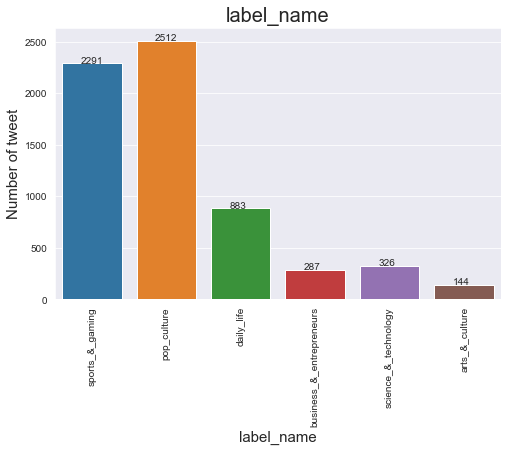

In [7]:
#visualizing the Customers' Requests
fig,ax = plt.subplots(figsize = (8,5))
sns.countplot('label_name', data = df)
for i in ax.patches:
    ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title("label_name",fontsize = 20)
plt.xlabel("label_name", fontsize = 15)
plt.xticks(rotation = 90) 
plt.ylabel("Number of tweet",fontsize = 15)
plt.show()

**Observation**

There is imbalance in the dataset, it has more tweet about sport&gaming and pop_culture than other labels

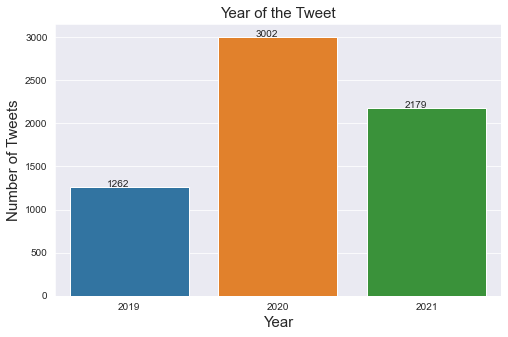

In [8]:
# checking the date
date =pd.DatetimeIndex(df.date).year
#visualizing the Customers' Resquest
fig,ax = plt.subplots(figsize = (8,5))
sns.countplot(date)
for i in ax.patches:
    ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title("Year of the Tweet",fontsize = 15)
plt.xlabel("Year",fontsize = 15) 
plt.ylabel("Number of Tweets",fontsize = 15)
plt.show()

As expected, more tweet in 2020 majorly because of the pandemic. 

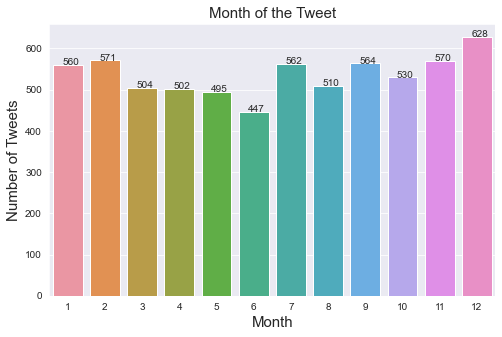

In [9]:
# checking the date
month =pd.DatetimeIndex(df.date).month
#visualizing the Customers' Resquest
fig,ax = plt.subplots(figsize = (8,5))
sns.countplot(month)
for i in ax.patches:
    ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title("Month of the Tweet",fontsize = 15)
plt.xlabel("Month",fontsize = 15) 
plt.ylabel("Number of Tweets",fontsize = 15)
plt.show()

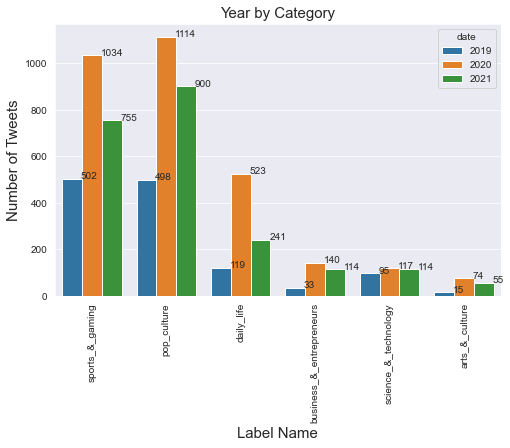

In [10]:
fig,ax = plt.subplots(figsize = (8,5))
sns.countplot(df.label_name, hue = date)
for i in ax.patches:
    ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title("Year by Category",fontsize = 15)
plt.xlabel("Label Name",fontsize = 15) 
plt.xticks(rotation = 90) 
plt.ylabel("Number of Tweets",fontsize = 15)
plt.show()

In [11]:
#subsetting the necessary columns
data = df[['text', 'label']]
data.head()

,text,label
0,The {@Clinton LumberKings@} beat the {@Cedar R...,4
1,I would rather hear Eli Gold announce this Aub...,4
2,"Someone take my phone away, I’m trying to not ...",4
3,"A year ago, Louisville struggled to beat an FC...",4
4,Anyone know why the #Dodgers #Orioles game nex...,4


## Pipeline 1
**Regex -> CountVectorizer -> ML models** 

In [12]:
#cleaning with regex

import re
def clean_text(text):
    # Remove everything in curly brackets
    text = re.sub(r'\{[^}]*\}', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #removing via
    text = re.sub(r'\bvia\b', '', text)
    return text
data['clean_text'] = data['text'].apply(clean_text)

In [13]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['label'], test_size=0.2, random_state=42)

# create the CountVectorizer object and fit it on the training data
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

# transform the training and test data
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#handling imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_vec, y_train)
# Define models
models = [('Logistic Regression', LogisticRegression()),
          ('Naive Bayes', MultinomialNB()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('Support Vector Machine', SVC())]
results = []
for name, model in models:
    # Fit the model on the training data
    model.fit(X_resampled, y_resampled)
    # Make predictions on the testing data
    y_pred = model.predict(X_test_vec)
    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Add the results to the list
    results.append((name, accuracy, f1))

# Convert the results to a DataFrame
pipe1 = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

# Print the results
pipe1

,Model,Accuracy,F1 Score
0,Logistic Regression,0.718386,0.731548
1,Naive Bayes,0.785105,0.775789
2,Random Forest,0.615981,0.632770
3,Gradient Boosting,0.647013,0.677930
4,Support Vector Machine,0.633049,0.617191


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

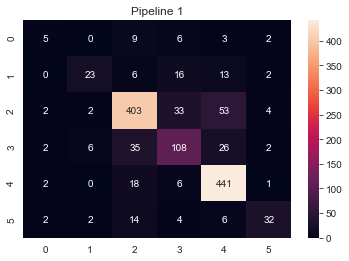

In [18]:
nvb = MultinomialNB()
nvb.fit(X_resampled, y_resampled)
y_pred = nvb.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.title('Pipeline 1')
plt.plot()

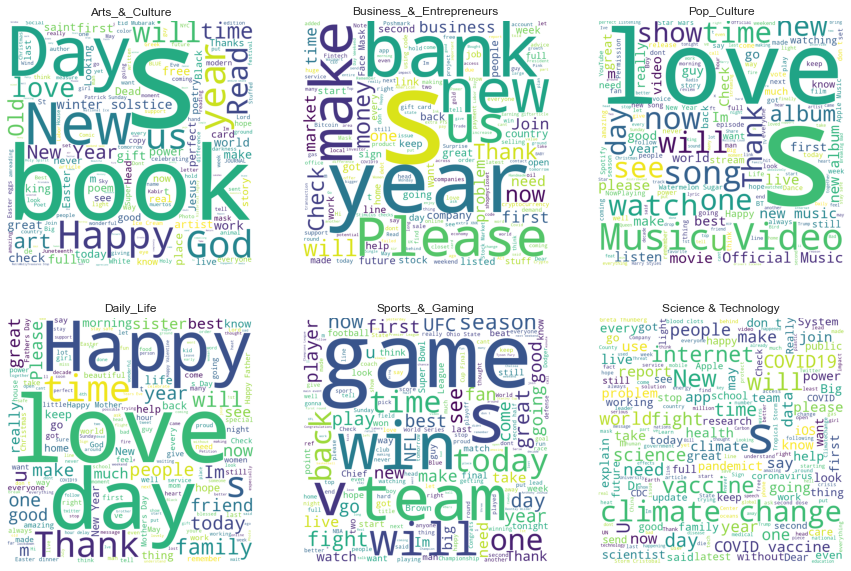

In [19]:
#Visualising common words for each category
# separate the dataset by label
label_0 = data[data['label'] == 0]
label_1 = data[data['label'] == 1]
label_2 = data[data['label'] == 2]
label_3 = data[data['label'] == 3]
label_4 = data[data['label'] == 4]
label_5 = data[data['label'] == 5]
# concatenate all of the clean_text for each label into a single string
clean_text_0 = ' '.join(label_0['clean_text'].tolist())
clean_text_1 = ' '.join(label_1['clean_text'].tolist())
clean_text_2 = ' '.join(label_2['clean_text'].tolist())
clean_text_3 = ' '.join(label_3['clean_text'].tolist())
clean_text_4 = ' '.join(label_4['clean_text'].tolist())
clean_text_5 = ' '.join(label_5['clean_text'].tolist())
# create a word cloud for each label
wordcloud_0 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_0)
wordcloud_1 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_1)
wordcloud_2 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_2)
wordcloud_3 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_3)
wordcloud_4 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_4)
wordcloud_5 = WordCloud(width=800, height=800, background_color='white').generate(clean_text_5)
# plot the word clouds for each label
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(wordcloud_0)
axs[0, 0].set_title('Arts_&_Culture')
axs[0, 0].axis('off')
axs[0, 1].imshow(wordcloud_1)
axs[0, 1].set_title('Business_&_Entrepreneurs')
axs[0, 1].axis('off')
axs[0, 2].imshow(wordcloud_2)
axs[0, 2].set_title('Pop_Culture')
axs[0, 2].axis('off')
axs[1, 0].imshow(wordcloud_3)
axs[1, 0].set_title('Daily_Life')
axs[1, 0].axis('off')
axs[1, 1].imshow(wordcloud_4)
axs[1, 1].set_title('Sports_&_Gaming')
axs[1, 1].axis('off')
axs[1, 2].imshow(wordcloud_5)
axs[1, 2].set_title('Science & Technology')
axs[1, 2].axis('off')
plt.show()

## PIPELINE 2
**Regex->TFIDF_vec -> ML Models**

In [20]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['label'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#handling imbalance using SMOTE
smote = SMOTE()
new_X, y_new = smote.fit_resample(X_train_tfidf, y_train)
# Define models
models = [('Logistic Regression', LogisticRegression()),
          ('Naive Bayes', MultinomialNB()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('Support Vector Machine', SVC())]
results = []
for name, mod in models:
    # Fit the model on the training data
    mod.fit(new_X, y_new)
    # Make predictions on the testing data
    y_pred = mod.predict(X_test_tfidf)
    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Add the results to the list
    results.append((name, accuracy, f1))

# Convert the results to a DataFrame
pipe2 = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

# Print the results
pipe2

,Model,Accuracy,F1 Score
0,Logistic Regression,0.771916,0.773152
1,Naive Bayes,0.740109,0.754503
2,Random Forest,0.692785,0.665972
3,Gradient Boosting,0.710628,0.704584
4,Support Vector Machine,0.737781,0.705523


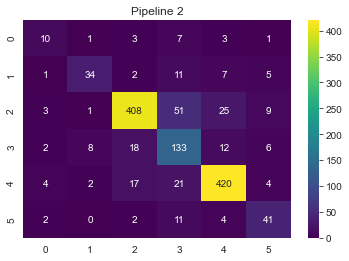

In [27]:
logmodel =LogisticRegression()
logmodel.fit(new_X, y_new)
y_pred = logmodel.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Pipeline 2')
plt.show()

## 

## PIPELINE 3  
**NLTK->TFIDF->ML Models**

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

nltk.download('stopwords')
nltk.download('wordnet')

# Define the stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Lemmatize and stem the tokens, and remove stop words
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens if token not in stop_words]
    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
data['preprocess'] = data['text'].apply(clean_text)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['preprocess'], data['label'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)
#handling imbalance using SMOTE
smote = SMOTE()
new_X, y_new = smote.fit_resample(X_train_tfidf, y_train)

In [25]:
#Define models
models = [('Logistic Regression', LogisticRegression()),
          ('Naive Bayes', MultinomialNB()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('Support Vector Machine', SVC())]
results = []
for name, mod in models:
    # Fit the model on the training data
    mod.fit(new_X, y_new)
    # Make predictions on the testing data
    y_pred = mod.predict(X_test_tfidf)
    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Add the results to the list
    results.append((name, accuracy, f1))

# Convert the results to a DataFrame
pipe3 = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

# Print the results
pipe3

,Model,Accuracy,F1 Score
0,Logistic Regression,0.811482,0.814874
1,Naive Bayes,0.783553,0.796684
2,Random Forest,0.747867,0.731710
3,Gradient Boosting,0.743988,0.748810
4,Support Vector Machine,0.784329,0.755742


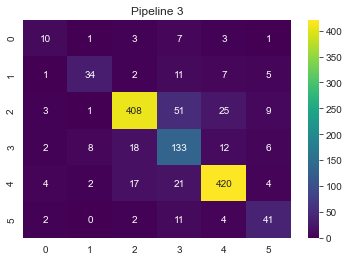

In [29]:
logmodel1 =LogisticRegression()
logmodel1.fit(new_X, y_new)
y_pred = logmodel1.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Pipeline 3')
plt.show()

## PIPELINE 4
**SPACY->TFIDF->ML Models**

In [30]:
# Define a function to clean the text using spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clean_text(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    # Lemmatize the tokens and remove punctuation and stopwords
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text

# Apply the clean_text function to the text column in the DataFrame
df['clean_text'] = df['text'].apply(clean_text)

# Apply the TF-IDF vectorizer to convert the text into numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Use SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# Define models
models = [('Logistic Regression', LogisticRegression()),
          ('Naive Bayes', MultinomialNB()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('Support Vector Machine', SVC())]
results = []
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train_res, y_train_res)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Add the results to the list
    results.append((name, accuracy, f1))

# Convert the results to a DataFrame
pipe4= pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

# Print the results
pipe4

,Model,Accuracy,F1 Score
0,Logistic Regression,0.801345,0.798506
1,Naive Bayes,0.768236,0.784412
2,Random Forest,0.738231,0.718864
3,Gradient Boosting,0.743404,0.748080
4,Support Vector Machine,0.759441,0.719030


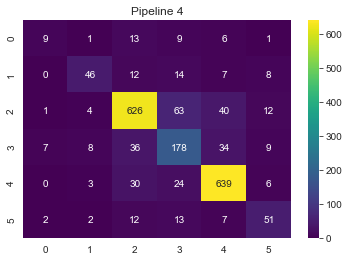

In [31]:
logmodel2 =LogisticRegression()
logmodel2.fit(X_train_res, y_train_res)
y_pred = logmodel2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Pipeline 4')
plt.show()

## PIPELINE 5
**Regex + NLTK -> Word2Vec-> ML Models**

In [34]:
w2v = api.load('glove-twitter-50')

In [35]:
#cleaning
def process_text(text):
    # Remove everything in curly brackets
    text = re.sub(r'\{[^}]*\}', '', text)
    #removing via
    text = re.sub(r'\bvia\b', '', text)
     # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Lemmatize and stem the tokens, and remove stop words
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens if token not in stop_words]
    return tokens
data['token'] = data['text'].apply(process_text)

In [36]:
#vectorizing
def vectorize(text):
    vector_size = w2v.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in text:
        if w in w2v:
            ctr += 1
            wv_res += w2v[w]
    wv_res = wv_res/ctr
    return wv_res
data['vector'] = data['token'].apply(vectorize)

In [37]:
X = data['vector'].to_list()
y = data['label'].to_list()
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#handling imbalance using SMOTE
smote = SMOTE()
w2v_X, y_w2v = smote.fit_resample(X_train, y_train)
# Define models
models = [('Logistic Regression', LogisticRegression()),
                    ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('Support Vector Machine', SVC())]
results = []
for name, model in models:
    # Fit the model on the training data
    model.fit(w2v_X, y_w2v)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Add the results to the list
    results.append((name, accuracy, f1))

# Convert the results to a DataFrame
pipe5 = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

# Print the results
pipe5

,Model,Accuracy,F1 Score
0,Logistic Regression,0.686579,0.712786
1,Random Forest,0.716835,0.721303
2,Gradient Boosting,0.691234,0.709011
3,Support Vector Machine,0.702870,0.724079


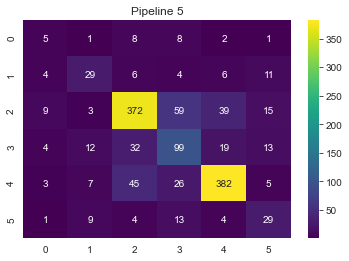

In [38]:
rfc =RandomForestClassifier()
rfc.fit(w2v_X, y_w2v)
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Pipeline 5')
plt.show()